# Machine Learning Challenge 2018

## Classificazione

In [2]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
from os import path
import numpy as np
from torchvision import transforms


# creazione della classe che ci permette di caricare le immagini e le relative etichette
class Dataset(Dataset):
    """Implementa l'oggetto ClassificationDataset che ci permette di caricare
    le immagini del dataset images"""

    def __init__(self, base_path, csv_list, transform=None):
        """Input:
            base_path: il path alla cartella contenente le immagini
            txt_list: il path al file di testo contenente la lista delle immagini
                        con le relative etichette. Ad esempio train.csv o test.csv.
            transform: implementeremo il dataset in modo che esso supporti le trasformazioni"""
        # conserviamo il path alla cartella contenente le immagini
        self.base_path = base_path
        # carichiamo la lista dei file
        # sarà una matrice con n righe (numero di immagini) e 2 colonne (path, etichetta)
        #self.images = np.loadtxt(csv_list, dtype=str, delimiter=',', usecols=(0,5))
        # sarà una matrice con n righe (numero di immagini) e 6 colonne (path, x, y, u, v, etichetta)
        self.images = np.loadtxt(csv_list, dtype=str, delimiter=',')
        
        # permutiamo i dati
        np.random.seed(1234) #impostiamo un seed per avere risultati ripetibili
        torch.random.manual_seed(1234);
        
        idx = np.random.permutation(len(self.images))
        self.images = self.images[idx]
        #print self.images

        # conserviamo il riferimento alla trasformazione da applicare
        self.transform = transform

    def __getitem__(self, index):
        # recuperiamo il path dell'immagine di indice index e la relativa etichetta
        #f, c = self.images[index]
        # recuperiamo il path dell'immagine di indice index, x, y, u, v e la relativa etichetta
        f,x,y,u,v,c = self.images[index]

        # carichiamo l'immagine utilizzando PIL
        im = Image.open(path.join(self.base_path, f))

        # se la trasfromazione è definita, applichiamola all'immagine
        if self.transform is not None:
            im = self.transform(im)

        # convertiamo l'etichetta in un intero
        label = int(c)

        # restituiamo un dizionario contenente immagine etichetta
        #return {'image': im, 'label': label}
        # restituiamo un dizionario contenente immagine etichetta posa
        return {'image': im, 'label': label, 'pose': np.array([x,y,u,v], dtype='float')}

    # restituisce il numero di campioni: la lunghezza della lista "images"
    def __len__(self):
        return len(self.images)

Costruiamo quindi il nostro training set ed il validation set:

In [3]:
# training set
train = Dataset('dataset/images','dataset/training_list.csv',transform=transforms.ToTensor())
sample = train[0]
#l'immagine è 3 x 144 x 256 perché è una immagine a colori
print "Immagine di train:", sample['image'].shape
print "Etichetta:", sample['label']
print "Posa:", sample['pose']

print ""

# validation set
valid = Dataset('dataset/images','dataset/validation_list.csv',transform=transforms.ToTensor())
sample = valid[0]
#l'immagine è 3 x 144 x 256 perché è una immagine a colori
print "Immagine di validation:", sample['image'].shape
print "Etichetta:", sample['label']
print "Posa:", sample['pose']

Immagine di train: torch.Size([3, 144, 256])
Etichetta: 14
Posa: [16.397331 -4.223821 -0.999388 -0.034932]

Immagine di validation: torch.Size([3, 144, 256])
Etichetta: 15
Posa: [-19.630225   2.979609   0.038931   0.999242]


Effettuiamo adesso la normalizzazione, e poi per ridurre i tempi computazionali lavoriamo con immagini più piccole, 32x56.

In [4]:
# per il training set

#procedura per calcolare la media
m = np.zeros(3)

for sample in train:
    m+=sample['image'].sum(1).sum(1) #accumuliamo la somma dei pixel canale per canale
#dividiamo per il numero di immagini moltiplicato per il numero di pixel
m=m/(len(train)*144*256)

#procedura simile per calcolare la deviazione standard
s = np.zeros(3)

for sample in train:
    s+=((sample['image']-torch.Tensor(m).view(3,1,1))**2).sum(1).sum(1)
s=np.sqrt(s/(len(train)*144*256))

# media e devST per i 3 canali
print "Medie",m
print "Dev.Std.",s

Medie [0.38766563 0.36472213 0.35473528]
Dev.Std. [0.21211976 0.21056999 0.21186012]


Inseriamo la corretta normalizzazione tra le trasformazioni:

In [5]:
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize(m,s),
                               transforms.Lambda(lambda x: x.view(-1))]) #per trasformare l'immagine in un unico vettore
train = Dataset('dataset/images','dataset/training_list.csv',transform=transform)
print "Immagine di train:", train[0]['image'].shape # 3x32x56
print "Etichetta:", train[0]['label']
print "Posa:", train[0]['pose']

print ""

valid = Dataset('dataset/images','dataset/validation_list.csv',transform=transform)
print "Immagine di validation:", valid[0]['image'].shape # 3x32x54
print "Etichetta:", valid[0]['label']
print "Posa:", valid[0]['pose']

Immagine di train: torch.Size([5376])
Etichetta: 14
Posa: [16.397331 -4.223821 -0.999388 -0.034932]

Immagine di validation: torch.Size([5376])
Etichetta: 15
Posa: [-19.630225   2.979609   0.038931   0.999242]


Ogni immagine (sia di train che di validation) quindi è stata normalizzata e trasformata in un vettore. Per effetuare l'ottimizzazione mediante SGD dobbiamo suddividere i campioni in mini-batch. Inoltre è importante fornire i campioni in ordine casuale.
PyTorch ci permette di gestire il "batching" in automatico e in maniera multithread mediante l'oggetto *DataLoader*. Utilizziamo un batch size di 64 immagini e due thread paralleli per velocizzare il caricamento dei dati:

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=64, num_workers=2, shuffle=True)
#shuffle permette di accedere ai dati in maniera casuale
valid_loader = DataLoader(valid, batch_size=64, num_workers=2)

I data loader sono degli oggetti iterabili. Possiamo dunque accedere ai diversi batch in maniera sequenziale all'interno di un ciclo for. Proviamo ad accedere al primo batch e interrompiamo il ciclo:

In [7]:
for batch in train_loader: #161 batch dove ogni batch contiene 64 immagini
    break
print batch['image'].shape
print batch['label'].shape
print batch['pose'].shape
# il batch contiene 64 vettori di training (immagini) di dimensione 5376, e altrettante etichette e pose corrispondenti

torch.Size([64, 5376])
torch.Size([64])
torch.Size([64, 4])


### Allenamento mediante SGD
Adesso siamo pronti per effettuare il training mediante Stochastic Gradient Descent. Utilizzeremo due cicli for, uno esterno per iterare lungo le epoche e uno interno per iterare lungo i batch. Il resto della procedura di training resta uguale. Per monitorare il training, all'interno di ogni epoca effettueremo un ciclo di training e un ciclo di test. Con dataset grandi, la procedura di training può essere lunga. Pertanto salveremo una copia del modello ad ogni iterazione.

In [8]:
from torch import nn
class SoftMaxRegressor(nn.Module):
    def __init__(self, in_features, out_classes):
        """Costruisce un regressore softmax.
            Input:
                in_features: numero di feature in input (es. 4)
                out_classes: numero di classi in uscita (es. 3)"""
        super(SoftMaxRegressor, self).__init__() #richiamo il costruttore della superclasse
        #questo passo è necessario per abilitare alcuni meccanismi automatici dei moduli di PyTorch
        self.linear = nn.Linear(in_features,out_classes) #il regressore softmax restituisce
        #distribuzioni di probabilità, quindi il numero di feature di output coincide con il numero di classi
        self.softmax = nn.Softmax(dim=1) #dim=1 indica che il softmax verrà calcolato riga per riga
    def forward(self,x):
        """Definisce come processare l'input x"""
        scores = self.linear(x)
        #anche in questo caso vogliamo evitare di applicare il softmax in fase di training
        if self.training: #se il modulo è in fase di training
            #la proprietà "training" è messa a disposizione dai meccanismi
            #automatici dei moduli di PyTorch
            return scores
        else: #se siamo in fase di test, calcoliamo le probabilità
            return self.softmax(scores)

In [9]:
from torch.optim import SGD
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

lr = 0.001
epochs = 10
#5376 feature in ingresso e 16 classi
model = SoftMaxRegressor(5376,16)
criterion = nn.CrossEntropyLoss()
#l'optimizer ci permetterà di effettuare la Stochastic Gradient Descent
optimizer = SGD(model.parameters(),lr)
training_losses = []
training_accuracies = []
valid_losses = []
valid_accuracies = []
for e in range(epochs):
    #ciclo di training
    model.train()
    train_loss = 0
    train_acc = 0
    for i, batch in enumerate(train_loader):
        #trasformiamo i tensori in variabili
        x=Variable(batch['image'])
        y=Variable(batch['label'])
        output = model(x)
        l = criterion(output,y)
        l.backward()
        acc = accuracy_score(y.data,output.max(1)[1].data)
        #accumuliamo i valori di training e loss
        #moltiplichiamo per x.shape[0], che restituisce la dimensione
        #del batch corrente.
        train_loss+=l.data[0]*x.shape[0]
        train_acc+=acc*x.shape[0]
        print "\r[TRAIN] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f" %  \
                (e+1,epochs,i,len(train_loader),l.data[0],acc),
        optimizer.step() #sostituisce il codice di aggiornamento manuale dei parametri
        optimizer.zero_grad() #sostituisce il codice che si occupava di azzerare i gradienti
    train_loss/=len(train)
    train_acc/=len(train)
    training_losses.append(train_loss)
    training_accuracies.append(train_acc)
    print "\r[TRAIN] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f" %  \
                (e+1,epochs,i,len(train_loader),train_loss,train_acc)
    #ciclo di test
    model.eval()
    valid_acc=0
    valid_loss=0
    for i, batch in enumerate(valid_loader):
        #trasformiamo i tensori in variabili
        x=Variable(batch['image'], requires_grad=False)
        y=Variable(batch['label'], requires_grad=False)
        output = model(x)
        l = criterion(output,y)
        valid_acc += accuracy_score(y.data,output.max(1)[1].data)*x.shape[0]
        valid_loss += l.data[0]*x.shape[0]
        print "\r[VALID] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f" %  \
                (e+1,epochs,i,len(valid_loader),l.data[0],acc),
    #salviamo il modello
    torch.save(model.state_dict(),'model-%d.pth'%(e+1,))
    valid_loss/=len(valid)
    valid_acc/=len(valid)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    print "\r[VALID] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f" %  \
                (e+1,epochs,i,len(valid_loader),valid_loss,valid_acc)

[TRAIN] Epoch 1/10. Iteration 160/161. Loss: 2.15. Accuracy: 0.37                             
[VALID] Epoch 1/10. Iteration 48/49. Loss: 2.62. Accuracy: 0.40                   
[TRAIN] Epoch 2/10. Iteration 160/161. Loss: 1.77. Accuracy: 0.50                                                                    
[VALID] Epoch 2/10. Iteration 48/49. Loss: 2.58. Accuracy: 0.44               
[TRAIN] Epoch 3/10. Iteration 160/161. Loss: 1.62. Accuracy: 0.55                            
[VALID] Epoch 3/10. Iteration 48/49. Loss: 2.55. Accuracy: 0.47                 
[TRAIN] Epoch 4/10. Iteration 160/161. Loss: 1.51. Accuracy: 0.58                                 
[VALID] Epoch 4/10. Iteration 48/49. Loss: 2.54. Accuracy: 0.48                    
[TRAIN] Epoch 5/10. Iteration 160/161. Loss: 1.43. Accuracy: 0.61                                                            
[VALID] Epoch 5/10. Iteration 48/49. Loss: 2.53. Accuracy: 0.50                 
[TRAIN] Epoch 6/10. Iteration 160/161. Loss:

Plottiamo accuracy e loss di training e validation

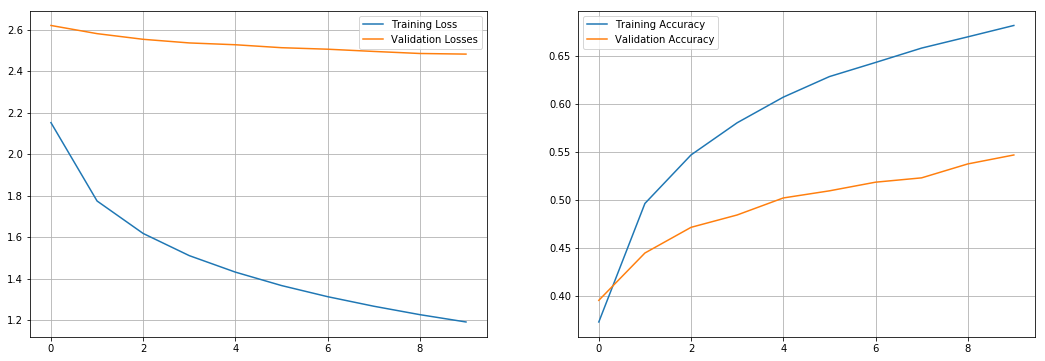

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(training_losses)
plt.plot(valid_losses)
plt.legend(['Training Loss','Validation Losses'])
plt.grid()
plt.subplot(122)
plt.plot(training_accuracies)
plt.plot(valid_accuracies)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.grid()
plt.show()